In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm

from train_test import train, test

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST Dataset

In [2]:
VAL_SIZE = 0.1
BATCH_SIZE = 64

# download the training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./root',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# split the training set into train and validation sets
train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)),
                                                    train_dataset.targets,
                                                    stratify=train_dataset.targets,
                                                    test_size=VAL_SIZE)

train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# now create the batches of the train, val, test sets
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

844
94
157


torch.Size([28, 28])


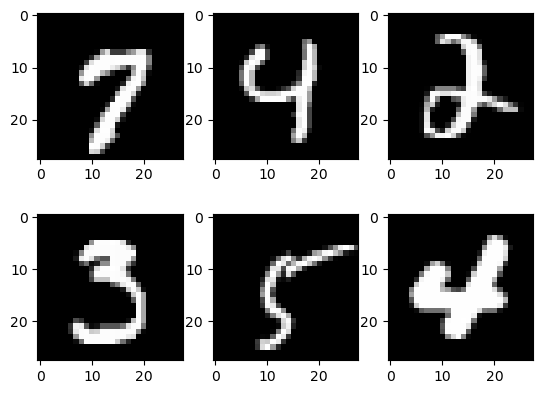

In [3]:
# show some samples from test set

samples = iter(test_loader)
sample_data, sample_targets = next(samples)
print((sample_data[0][0]).size())

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_data[i][0], cmap='gray')
plt.show()

## Model

In [4]:
# vgg style convolutional neural network
class VGG(nn.Module):
    def __init__(self, num_classes):
        super(VGG, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False)
        self.conv1_2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False)
        self.conv1_1bn = nn.BatchNorm2d(8)
        self.conv1_2bn = nn.BatchNorm2d(8)
        
        self.conv2_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, bias=False)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False)
        self.conv2_1bn = nn.BatchNorm2d(16)
        self.conv2_2bn = nn.BatchNorm2d(16)
        
        self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, bias=False)
        self.conv3_1bn = nn.BatchNorm2d(32)
        self.conv3_2bn = nn.BatchNorm2d(32)
        
        # here we have two options use adaptive pooling to reduce the tensor into 1-dimensions
        # or use the moltiplication of the last layer to linearize this one
        
        # case adaptive pooling
        # self.adaptpool = nn.AdaptiveAvgPool2d((1,1))
        # self.fc1 = nn.Linear(3, 128)
        # self.fc2 = nn.Linear(128, 10)
        
        # case linearization last convolutional layer, this one is used in the original vgg
        self.fc1 = nn.Linear(3*3*32, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # add the other functions
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # (2,2) halves the dimension of the output
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # first convolutional block
        x = self.relu(self.conv1_1bn(self.conv1_1(x)))
        x = self.relu(self.conv1_2bn(self.conv1_2(x)))
        x = self.maxpool(x)
        
        # second convolutional block
        x = self.relu(self.conv2_1bn(self.conv2_1(x)))
        x = self.relu(self.conv2_2bn(self.conv2_2(x)))
        x = self.maxpool(x)
        
        # third convolutional block
        x = self.relu(self.conv3_1bn(self.conv3_1(x)))
        x = self.relu(self.conv3_2bn(self.conv3_2(x)))
        x = self.maxpool(x)
        
        # fully connected block
        x = x.reshape(x.shape[0], -1) # flatten the out in a single vector
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x 

In [5]:
num_classes = 10
model = VGG(num_classes).to(device)
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 8, 28, 28]           72
├─BatchNorm2d: 1-2                       [64, 8, 28, 28]           16
├─ReLU: 1-3                              [64, 8, 28, 28]           --
├─Conv2d: 1-4                            [64, 8, 28, 28]           576
├─BatchNorm2d: 1-5                       [64, 8, 28, 28]           16
├─ReLU: 1-6                              [64, 8, 28, 28]           --
├─MaxPool2d: 1-7                         [64, 8, 14, 14]           --
├─Conv2d: 1-8                            [64, 16, 14, 14]          1,152
├─BatchNorm2d: 1-9                       [64, 16, 14, 14]          32
├─ReLU: 1-10                             [64, 16, 14, 14]          --
├─Conv2d: 1-11                           [64, 16, 14, 14]          2,304
├─BatchNorm2d: 1-12                      [64, 16, 14, 14]          32
├─ReLU: 

## Training and Validation the Model

In [6]:
# loss and optmizer
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
EPOCHS = 5 #100

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    print('\n')
    val_epoch_loss, val_epoch_acc = test(model, val_loader, criterion)
    
    print('\n')
    print(f"training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}%")
    print(f"validation loss: {val_epoch_loss:.3f}, validation acc: {val_epoch_acc:.3f}%")
    print('-'*50)

[INFO]: Epoch 1 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.670, training acc: 65.002%
validation loss: 1.029, validation acc: 85.550%
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.673, training acc: 90.235%
validation loss: 0.427, validation acc: 93.050%
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.328, training acc: 94.270%
validation loss: 0.248, validation acc: 95.283%
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.215, training acc: 95.639%
validation loss: 0.181, validation acc: 96.050%
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.165, training acc: 96.274%
validation loss: 0.145, validation acc: 96.667%
--------------------------------------------------


In [8]:
"""
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './model.pth')
""";